In [2]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
# To install this module, run:
# python -m pip install Pillow
from PIL import Image, ImageDraw
from IPython.display import display


from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person

In [3]:
# This key will serve all examples in this document.
KEY = "2a01a8ec414346c2b920e4e26b3ec8d2"

# This endpoint will be used in all examples in this quickstart.
ENDPOINT = "https://pl-face-api.cognitiveservices.azure.com/"

In [4]:
# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

# Detect faces

In [5]:
# Detect a face in an image that contains a single face
single_face_image_url = 'https://www.biography.com/.image/t_share/MTQ1MzAyNzYzOTgxNTE0NTEz/john-f-kennedy---mini-biography.jpg'
single_image_name = os.path.basename(single_face_image_url)
# We use detection model 3 to get better performance.
detected_faces = face_client.face.detect_with_url(url=single_face_image_url, detection_model='detection_03')
if not detected_faces:
    raise Exception('No face detected from image {}'.format(single_image_name))

# Display the detected face ID in the first single-face image.
# Face IDs are used for comparison to faces (their IDs) detected in other images.
print('Detected face ID from', single_image_name, ':')
for face in detected_faces: print (face.face_id)
print()

# Save this ID for use in Find Similar
first_image_face_ID = detected_faces[0].face_id

Detected face ID from john-f-kennedy---mini-biography.jpg :
53e60423-93ad-4975-b057-72acf9aed4db



# Display and frame faces

Drawing rectangle around face... see popup for results.


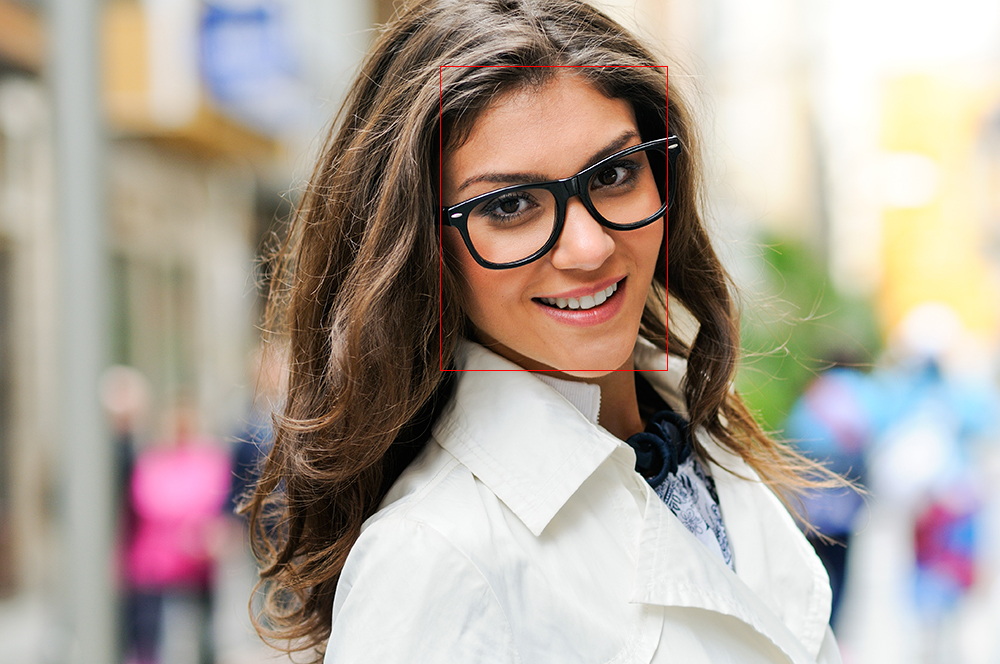

In [6]:
# Detect a face in an image that contains a single face
single_face_image_url = 'https://raw.githubusercontent.com/Microsoft/Cognitive-Face-Windows/master/Data/detection1.jpg'
single_image_name = os.path.basename(single_face_image_url)
# We use detection model 3 to get better performance.
detected_faces = face_client.face.detect_with_url(url=single_face_image_url, detection_model='detection_03')
if not detected_faces:
    raise Exception('No face detected from image {}'.format(single_image_name))

# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

def drawFaceRectangles() :
# Download the image from the url
    response = requests.get(single_face_image_url)
    img = Image.open(BytesIO(response.content))

# For each face returned use the face rectangle and draw a red box.
    print('Drawing rectangle around face... see popup for results.')
    draw = ImageDraw.Draw(img)
    for face in detected_faces:
        draw.rectangle(getRectangle(face), outline='red')

# Display the image in the default image browser.
    #img.show()
    display(img)

# Uncomment this to show the face rectangles.
drawFaceRectangles()

## Find Similar Faces

In [9]:
# Detect the faces in an image that contains multiple faces
# Each detected face gets assigned a new ID
multi_face_image_url = "http://www.historyplace.com/kennedy/president-family-portrait-closeup.jpg"
multi_image_name = os.path.basename(multi_face_image_url)
# We use detection model 3 to get better performance.
detected_faces2 = face_client.face.detect_with_url(url=multi_face_image_url, detection_model='detection_03')
detected_faces2

In [11]:
# Search through faces detected in group image for the single face from first image.
# First, create a list of the face IDs found in the second image.
second_image_face_IDs = list(map(lambda x: x.face_id, detected_faces2))
# Next, find similar face IDs like the one detected in the first image.
similar_faces = face_client.face.find_similar(face_id=first_image_face_ID, face_ids=second_image_face_IDs)
if not similar_faces:
    print('No similar faces found in', multi_image_name, '.')
# Print the details of the similar faces detected
else:
    print('Similar faces found in', multi_image_name + ':')
    for face in similar_faces:
        first_image_face_ID = face.face_id
        # The similar face IDs of the single face image and the group image do not need to match, 
        # they are only used for identification purposes in each image.
        # The similar faces are matched using the Cognitive Services algorithm in find_similar().
        face_info = next(x for x in detected_faces2 if x.face_id == first_image_face_ID)
        if face_info:
            print('  Face ID: ', first_image_face_ID)
            print('  Face rectangle:')
            print('    Left: ', str(face_info.face_rectangle.left))
            print('    Top: ', str(face_info.face_rectangle.top))
            print('    Width: ', str(face_info.face_rectangle.width))
            print('    Height: ', str(face_info.face_rectangle.height))

Similar faces found in president-family-portrait-closeup.jpg:
  Face ID:  f649d4dc-04de-4c53-b3cd-dfbaf70a9ea4
  Face rectangle:
    Left:  429
    Top:  43
    Width:  58
    Height:  78


# Create a person group

In [ ]:
# Used in the Person Group Operations and Delete Person Group examples.
# You can call list_person_groups to print a list of preexisting PersonGroups.
# SOURCE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
PERSON_GROUP_ID = "ms-team"

# Used for the Delete Person Group example.
TARGET_PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)

In [ ]:
'''
Create the PersonGroup
'''
# Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

# Define woman friend
woman = face_client.person_group_person.create(PERSON_GROUP_ID, "Woman")
# Define man friend
man = face_client.person_group_person.create(PERSON_GROUP_ID, "Man")
# Define child friend
child = face_client.person_group_person.create(PERSON_GROUP_ID, "Child")

#### Assign Faces

In [ ]:
'''
Detect faces and register to correct person
'''
# Find all jpeg images of friends in working directory
woman_images = [file for file in glob.glob('*.jpg') if file.startswith("w")]
man_images = [file for file in glob.glob('*.jpg') if file.startswith("m")]
child_images = [file for file in glob.glob('*.jpg') if file.startswith("ch")]

# Add to a woman person
for image in woman_images:
    w = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, woman.person_id, w)

# Add to a man person
for image in man_images:
    m = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, man.person_id, m)

# Add to a child person
for image in child_images:
    ch = open(image, 'r+b')
    face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, child.person_id, ch)

#### Train Person Group

In [ ]:
'''
Train PersonGroup
'''
print()
print('Training the person group...')
# Train the person group
face_client.person_group.train(PERSON_GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        face_client.person_group.delete(person_group_id=PERSON_GROUP_ID)
        sys.exit('Training the person group has failed.')
    time.sleep(5)

#### Identify a face

In [ ]:
'''
Identify a face against a defined PersonGroup
'''
# Group image for testing against
test_image_array = glob.glob('test-image-person-group.jpg')
image = open(test_image_array[0], 'r+b')

print('Pausing for 60 seconds to avoid triggering rate limit on free account...')
time.sleep (60)

# Detect faces
face_ids = []
# We use detection model 3 to get better performance.
faces = face_client.face.detect_with_stream(image, detection_model='detection_03')
for face in faces:
    face_ids.append(face.face_id)

# Verify Face

In [ ]:
# Base url for the Verify and Facelist/Large Facelist operations
IMAGE_BASE_URL = 'https://csdx.blob.core.windows.net/resources/Face/Images/'

In [ ]:
# Create a list to hold the target photos of the same person
target_image_file_names = ['Family1-Dad1.jpg', 'Family1-Dad2.jpg']
# The source photos contain this person
source_image_file_name1 = 'Family1-Dad3.jpg'
source_image_file_name2 = 'Family1-Son1.jpg'

In [ ]:
# Detect face(s) from source image 1, returns a list[DetectedFaces]
# We use detection model 3 to get better performance.
detected_faces1 = face_client.face.detect_with_url(IMAGE_BASE_URL + source_image_file_name1, detection_model='detection_03')
# Add the returned face's face ID
source_image1_id = detected_faces1[0].face_id
print('{} face(s) detected from image {}.'.format(len(detected_faces1), source_image_file_name1))

# Detect face(s) from source image 2, returns a list[DetectedFaces]
detected_faces2 = face_client.face.detect_with_url(IMAGE_BASE_URL + source_image_file_name2, detection_model='detection_03')
# Add the returned face's face ID
source_image2_id = detected_faces2[0].face_id
print('{} face(s) detected from image {}.'.format(len(detected_faces2), source_image_file_name2))

# List for the target face IDs (uuids)
detected_faces_ids = []
# Detect faces from target image url list, returns a list[DetectedFaces]
for image_file_name in target_image_file_names:
    # We use detection model 3 to get better performance.
    detected_faces = face_client.face.detect_with_url(IMAGE_BASE_URL + image_file_name, detection_model='detection_03')
    # Add the returned face's face ID
    detected_faces_ids.append(detected_faces[0].face_id)
    print('{} face(s) detected from image {}.'.format(len(detected_faces), image_file_name))

In [ ]:
# Verification example for faces of the same person. The higher the confidence, the more identical the faces in the images are.
# Since target faces are the same person, in this example, we can use the 1st ID in the detected_faces_ids list to compare.
verify_result_same = face_client.face.verify_face_to_face(source_image1_id, detected_faces_ids[0])
print('Faces from {} & {} are of the same person, with confidence: {}'
    .format(source_image_file_name1, target_image_file_names[0], verify_result_same.confidence)
    if verify_result_same.is_identical
    else 'Faces from {} & {} are of a different person, with confidence: {}'
        .format(source_image_file_name1, target_image_file_names[0], verify_result_same.confidence))

# Verification example for faces of different persons.
# Since target faces are same person, in this example, we can use the 1st ID in the detected_faces_ids list to compare.
verify_result_diff = face_client.face.verify_face_to_face(source_image2_id, detected_faces_ids[0])
print('Faces from {} & {} are of the same person, with confidence: {}'
    .format(source_image_file_name2, target_image_file_names[0], verify_result_diff.confidence)
    if verify_result_diff.is_identical
    else 'Faces from {} & {} are of a different person, with confidence: {}'
        .format(source_image_file_name2, target_image_file_names[0], verify_result_diff.confidence))